In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial2, comb
from scipy.interpolate import splrep, splev, interp1d
from numpy.polynomial.hermite import hermgauss
from py_vollib.black_scholes.implied_volatility import implied_volatility as bs_iv
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_vollib.black_scholes.implied_volatility import implied_volatility
from typing import Optional, Tuple, List
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.stats import norm
from py_vollib.black.implied_volatility import implied_volatility as iv_black
from py_vollib.black.implied_volatility import implied_volatility as iv_black
# Imp vol estimator based on P Jäckel's "Let's be rational"
vec_find_vol_rat = np.vectorize(implied_volatility)


In [52]:
class PDV:
    def __init__(self, theta1, theta2, S0, beta, lam1, lam2, T, n_steps, n_sims,Y_storage=None):
        """
        Initialisation du modèle PDV (Piecewise Deterministic Volatility).
        
        Parameters:
        -----------
        theta1, theta2 : float
            Paramètres de pondération pour R1 et R2
        S0 : float
            Prix initial de l'actif
        beta : List[float]
            Paramètres de volatilité [β₀, β₁, β₂]
        lam1, lam2 : List[float]
            Paramètres de vitesse de retour à la moyenne pour R1 et R2
        T : float
            Horizon temporel
        n_steps : int
            Nombre de pas de temps
        n_sims : int
            Nombre de simulations
        """
        self.theta1 = theta1
        self.theta2 = theta2
        self.S0 = S0
        self.beta = np.array(beta)
        self.lam1 = np.array(lam1)
        self.lam2 = np.array(lam2)
        self.T = T
        self.n_steps = n_steps
        self.dt = T / n_steps
        self.n_sims = n_sims
        
        # Initialisation des processus de volatilité réalisée
        self.R1 = np.zeros((n_steps + 1, n_sims, 2))
        self.R2 = np.zeros((n_steps + 1, n_sims, 2))
        
        # Stockage des résultats de simulation
        self.S = None
        self.volatility_paths = None
        if Y_storage is None:
            self.Y_storage = np.random.normal(0, 1, (n_sims, n_steps))
            self.Y_storage[:, 0] = 0
        else:
            self.Y_storage = Y_storage
        
    def set_initial_conditions(self, R1_init, R2_init):
        """
        Définit les conditions initiales pour R1 et R2.
        
        Parameters:
        -----------
        R1_init : np.ndarray, optional
            Conditions initiales pour R1, shape (n_sims, 2)
        R2_init : np.ndarray, optional
            Conditions initiales pour R2, shape (n_sims, 2)
        """
        if R1_init is not None:
            self.R1[0] = R1_init
        if R2_init is not None:
            self.R2[0] = R2_init

    def sigma(self, R1, R2) :
        """
        Calcule la volatilité σ(R1, R2) = β₀ + β₁*R1 + β₂*√R2⁺
        
        Parameters:
        -----------
        R1, R2 :
            Valeurs des processus de volatilité réalisée
            
        Returns:
        --------
            Volatilité instantanée
        """
        return self.beta[0] + self.beta[1] * R1 + self.beta[2] * np.sqrt(np.maximum(R2, 0))

    def R_array(self, t, n):
        """
        Calcule R1(t) ou R2(t) à l'instant t selon la pondération theta.
        
        Parameters:
        -----------
        t : int
            Indice temporel
        n : int
            1 pour R1, 2 pour R2
            
        Returns:
        --------
        np.ndarray
            Valeurs pondérées de R1 ou R2
        """
        if n == 1:
            return (1 - self.theta1) * self.R1[t, :, 0] + self.theta1 * self.R1[t, :, 1]
        elif n == 2:
            return (1 - self.theta2) * self.R2[t, :, 0] + self.theta2 * self.R2[t, :, 1]
        else:
            raise ValueError("n doit être 1 ou 2.")

    def simulate_paths(self):
        """
        Simule les trajectoires de S_t, R1_{j,t}, R2_{j,t} selon le modèle PDV.
        
        Returns:
        --------
        np.ndarray
            Trajectoires des prix, shape (n_steps+1, n_sims)
        """
        # Initialisation des prix
        S = np.zeros((self.n_steps + 1, self.n_sims))
        S[0, :] = self.S0
        # Stockage des volatilités pour analyse
        volatility_paths = np.zeros((self.n_steps + 1, self.n_sims))

        for t in range(self.n_steps):
            # Calcul des volatilités réalisées pondérées
            R1_t = self.R_array(t, n=1)
            R2_t = self.R_array(t, n=2)
            sigma_t = self.sigma(R1_t, R2_t)
            volatility_paths[t] = sigma_t

            # Simulation du mouvement brownien
            dW = np.sqrt(self.dt) * self.Y_storage[:,t]
            #dW = np.random.normal(0, np.sqrt(self.dt), size=self.n_sims)
            
            S[t + 1,:] = S[t,:] * np.exp(sigma_t * dW - 0.5*sigma_t**2*self.dt)

            for j in range(2):
                λ1 = self.lam1[j]
                λ2 = self.lam2[j]

                # Processus R1: dR1 = λ1 * (σ*dW - R1*dt)
                self.R1[t + 1, :, j] = (self.R1[t, :, j] + 
                                       λ1 * (sigma_t * dW - self.R1[t, :, j] * self.dt))
                
                # Processus R2: dR2 = λ2 * (σ² - R2) * dt
                self.R2[t + 1, :, j] = (self.R2[t, :, j] + 
                                       λ2 * (sigma_t**2 - self.R2[t, :, j]) * self.dt)

        # Dernière volatilité
        R1_final = self.R_array(self.n_steps, n=1)
        R2_final = self.R_array(self.n_steps, n=2)
        volatility_paths[self.n_steps] = self.sigma(R1_final, R2_final)
        
        # Stockage pour analyse ultérieure
        self.S = S
        self.volatility_paths = volatility_paths
        
        return S

    def compute_option_price(self, K, option_type="call") :
        """
        Calcule le prix d'une option européenne (call ou put) à l'échéance 
        en utilisant une simulation de Monte Carlo.

        Paramètres
        ----------
        K : float
            Prix d'exercice (strike) de l'option.
        option_type : str, optionnel
            Type de l'option : 'call' pour une option d'achat, 'put' pour une option de vente.
            Par défaut : 'call'.

        Retourne
        --------
        float
            Estimation du prix de l'option basé sur les trajectoires simulées du sous-jacent.

        Exceptions
        ----------
        ValueError :
            Si aucune trajectoire n’a été simulée ou si le type d’option est invalide.
        """

        if self.S is None:
            self.simulate_paths()
        
        final_prices = self.S[-1]
        
        if option_type == 'call':
            payoffs = np.maximum(final_prices - K, 0)
        elif option_type == 'put':
            payoffs = np.maximum(K - final_prices, 0)
        else:
            raise ValueError("option_type doit être 'call' ou 'put'")
        
        # Prix actualisé
        option_price = np.mean(payoffs)
        return option_price
            
    def compute_implied_volatility(self, K, option_type = "call") :
        """
        Calcule la volatilité implicite d'une option européenne à partir de son prix
        estimé par simulation Monte Carlo, en utilisant le modèle de Black-Scholes.

        Paramètres
        ----------
        K : float
            Prix d'exercice de l'option.
        option_type : str, optionnel
            Type de l'option : 'call' ou 'put'. Par défaut : 'call'.

        Retourne
        --------
        float
            Volatilité implicite estimée, ou NaN si le calcul échoue.
        """
        T = self.T
        
        r = 0.0
        price = self.compute_option_price(K, option_type)

        flag = 'c' if option_type == 'call' else 'p'

        try:
            iv = implied_volatility(price, self.S0, K, T, r, flag)
        except Exception as e:
            print(f"[implied_vol] Échec pour K={K}: {e}")
            return np.nan

        return iv


    def compute_volatility_smile(self, strikes, market_prices, 
                             option_type: str = 'call') :
        """
        Calcule la volatilité implicite pour une série de strikes à partir de prix de marché.

        Paramètres
        ----------
        strikes : List[float]
            Liste des prix d'exercice des options.
        market_prices : List[float]
            Liste des prix de marché correspondants aux options.
        option_type : str, optionnel
            'call' ou 'put' (par défaut : 'call').

        Retourne
        --------
        List[float]
            Liste des volatilités implicites correspondantes. NaN si le calcul échoue.
        """
        if len(strikes) != len(market_prices):
            raise ValueError("Les listes strikes et market_prices doivent avoir la même longueur")

        implied_vols = []
        flag = option_type[0]
        for K, market_price in zip(strikes, market_prices):
            try:
                vol = implied_volatility(market_price, self.S0, K, self.T, r=0, flag=flag)
                implied_vols.append(vol)
            except Exception:
                implied_vols.append(np.nan)
        return implied_vols


    def get_statistics(self) -> dict:
        """
        Calcule des statistiques sur les trajectoires simulées.
        
        Returns:
        --------
        dict
            Dictionnaire contenant diverses statistiques
        """
        if self.S is None:
            raise ValueError("Aucune simulation n'a été effectuée. Appelez simulate_paths() d'abord.")
        
        final_prices = self.S[-1]
        returns = np.diff(np.log(self.S), axis=0)
        
        stats = {
            'prix_final_moyen': np.mean(final_prices),
            'rendement_moyen': np.mean(returns),
            'volatilite_moyenne': np.mean(self.volatility_paths),
            'volatilite_std': np.std(self.volatility_paths),
            'prix_min': np.min(self.S),
            'prix_max': np.max(self.S)
        }
        
        return stats
    def plot_paths(self, n_paths = 5, figsize = (12, 6)):
        """
        Trace les trajectoires simulées sur 3 graphiques séparés :
        - Prix
        - Volatilité
        - Histogramme des prix finaux

        Parameters:
        -----------
        n_paths : int
            Nombre de trajectoires à tracer
        figsize : tuple
            Taille de chaque figure
        """
        if self.S is None:
            raise ValueError("Aucune simulation n'a été effectuée. Appelez simulate_paths() d'abord.")

        time_grid = np.linspace(0, self.T, self.n_steps + 1)

        # --- 1️⃣ Prix ---
        plt.figure(figsize=figsize)
        for i in range(n_paths):
            plt.plot(time_grid, self.S[:, i], label=f'Trajectoire {i+1}')
        plt.title('Trajectoires des prix')
        plt.xlabel('Temps')
        plt.ylabel('S_t')
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- 2️⃣ Volatilité ---
        plt.figure(figsize=figsize)
        for i in range(n_paths):
            plt.plot(time_grid, self.volatility_paths[:, i], label=f'Trajectoire {i+1}')
        plt.title('Trajectoires de volatilité')
        plt.xlabel('Temps')
        plt.ylabel('Volatilité')
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- 3️⃣ Distribution des prix finaux ---
        plt.figure(figsize=figsize)
        plt.hist(self.S[-1], bins=50, alpha=0.7, density=True, label='Distribution des prix finaux')
        plt.title('Distribution des prix finaux')
        plt.xlabel('Prix final')
        plt.ylabel('Densité')
        plt.legend()
        plt.grid(True)
        plt.show()




    def plot_volatility_smile(self, implied_vols, strikes, figsize=(12, 5)):
        """
        Trace le smile de volatilité implicite en fonction du strike.

        Paramètres
        ----------
        implied_vols : list of float
            Volatilités implicites.
        strikes : list of float
            Strikes correspondants.
        figsize : tuple
            Taille de la figure matplotlib.
        """
        implied_vols = np.array(implied_vols)
        strikes = np.array(strikes)

        valid_idx = ~np.isnan(implied_vols)
        valid_vols = implied_vols[valid_idx]
        valid_strikes = strikes[valid_idx]

        plt.figure(figsize=figsize)

        if len(valid_vols) > 0:
            plt.plot(valid_strikes, valid_vols, 'o-', color='blue', label='Vol implicite')
            plt.axvline(x=self.S0, color='red', linestyle='--', alpha=0.7, label=f'Spot ({self.S0})')
            plt.xlabel('Strike')
            plt.ylabel('Volatilité Implicite')
            plt.title('Smile de Volatilité')
            plt.grid(True)
            plt.legend()
        else:
            plt.text(0.5, 0.5, 'Aucune volatilité implicite valide',
                    transform=plt.gca().transAxes, ha='center', va='center')

        plt.tight_layout()
        plt.show()
    
    def price_vix_derivatives(self, delta_days = 30, 
                            n_subpaths_per_outer = 100, n_inner_steps= 200) :
        """
        Calcule le prix du future VIX, le prix d'un call vanilla sur VIX et sa volatilité implicite.

        Paramètres
        ----------
        delta_days : int
            Horizon du VIX en jours (par défaut : 30 jours).
        K : float
            Strike de l'option call sur le VIX.
        n_subpaths_per_outer : int
            Nombre de sous-trajectoires simulées pour chaque état à T.

        Retourne
        --------
        dict
            Contient : prix du future VIX, prix du call, probabilité ITM, volatilité implicite.
        """
        
        delta = delta_days / 365  # convertit l'horizon en fraction d'année
        dt_inner = delta / n_inner_steps

        R1_T = self.R1[-1]  # Récupère R1 à l'instant T pour toutes les simulations (n_sims, 2)
        R2_T = self.R2[-1]  # Idem pour R2

        vix_T_vals = []

        # Boucle sur chaque simulation principale (états atteints à T)
        for idx in range(self.n_sims):
            R1_0, R1_1 = R1_T[idx]
            R2_0, R2_1 = R2_T[idx]

            # On peut simuler plusieurs sous-trajectoires depuis le même état
            for _ in range(n_subpaths_per_outer):
                # Initialisation des processus R1 et R2
                R1 = np.zeros((n_inner_steps + 1, 2))
                R2 = np.zeros((n_inner_steps + 1, 2))
                R1[0] = [R1_0, R1_1]
                R2[0] = [R2_0, R2_1]

                sigma_sq_path = []

                # Simule une trajectoire future de sigma^2 de T à T+Δ
                for t in range(n_inner_steps):
                    # Calcule la volatilité à l'instant courant
                    R1_comb = (1 - self.theta1) * R1[t, 0] + self.theta1 * R1[t, 1]
                    R2_comb = (1 - self.theta2) * R2[t, 0] + self.theta2 * R2[t, 1]
                    sigma_t = self.sigma(R1_comb, R2_comb)

                    sigma_sq_path.append(sigma_t**2)

                    # Incrément brownien pour R1
                    dW = np.random.normal(0, np.sqrt(dt_inner))

                    for j in range(2):
                        λ1 = self.lam1[j]
                        λ2 = self.lam2[j]
                        R1[t + 1, j] = R1[t, j] + λ1 * (sigma_t * dW - R1[t, j] * dt_inner)
                        R2[t + 1, j] = R2[t, j] + λ2 * (sigma_t**2 - R2[t, j]) * dt_inner

                # Intégrale de sigma² sur [T, T+Δ] ≈ somme discrète
                mean_sigma_sq = np.sum(sigma_sq_path) * dt_inner
                
                vix_T = np.sqrt(mean_sigma_sq / delta) *100
                vix_T_vals.append(vix_T)

        vix_T_vals = np.array(vix_T_vals)
        print("vix t shape is ",vix_T_vals.shape)

        # Prix du future VIX ≈ moyenne des VIX simulés
        vix_fut_price = np.mean(vix_T_vals)
        print('vis fut price is ',vix_fut_price)
        call_prices = []
        strike_array = np.linspace(0.7,1.5,10)*vix_fut_price
        for K in strike_array:
            call_payoffs = np.maximum(vix_T_vals - K, 0)
            call_price = np.mean(call_payoffs)
            call_prices.append(call_price)

        print("call prices is ",call_prices)
        print('strike array is ',strike_array)
        # Volatilité implicite dans le modèle Black (sur le future VIX)
        implied_vol = []
        for K_i, C_i in zip(strike_array, call_prices):
            try:
                iv = iv_black(
                    C_i, vix_fut_price, K=K_i, t=delta, r=0.0, flag='c'
                )
                implied_vol.append(iv)
            except Exception as e:
                iv = np.nan
                print(f"[IV] Erreur calcul IV Black: {e}")

        return {
            'prix_future_VIX': vix_fut_price,
            'prix_call_VIX': call_prices,
            'vol_implicite': implied_vol,
            'strike':strike_array
        }
    def ssr(self, eps=1e-5, h=1e-4):
        atm_strike = self.S0 * np.exp(np.array([-h, 0, h]))
        # Compute skew at ATM
        iv_skew = []
        for K in atm_strike:
            self.set_initial_conditions([0, 0], [0, 0])
            self.simulate_paths()
            iv = self.compute_implied_volatility(K)
            iv_skew.append(iv)
        skew = (iv_skew[2] - iv_skew[0]) / (2 * h)

        # Compute sensitivity to R1[0]
        strike = self.S0
        self.set_initial_conditions([eps, 0], [0, 0])
        self.simulate_paths()
        iv_up = self.compute_implied_volatility(strike)
        self.set_initial_conditions([0, eps], [0, 0])
        self.simulate_paths()
        iv_down = self.compute_implied_volatility(strike)

        self.set_initial_conditions([0, 0], [0, 0])
        self.simulate_paths()
        iv_base = self.compute_implied_volatility(strike)
        d_iv_dr1_0 = (self.lam1[0]*iv_up + self.lam1[1]*iv_down -(self.lam1[0]+self.lam1[1]) * iv_base) / eps

        # Compute SSR
        ssr_value = d_iv_dr1_0 / skew

        return ssr_value, skew, d_iv_dr1_0




        
        



## cette semaine, lundi mardi 
## 9 au 18 Juillet congé
### détendre ce calcul de SSR vers 4 factor PDV model
### traçage des courbes
### voir le problème de SSR en 2 facteurs
### voir le SSR à un facteur et sa variance
# voir le skew peut etre le calculer c le skew, le nominateur qui varie et tracer les courbes des 3  
#  sigma² = fonction de tous les R 
## dynamique de R_2 ,n'a pas de W_t donc contient que 2 termes
## SSR continuous or discrete where t is almost equal to T dans le PDV



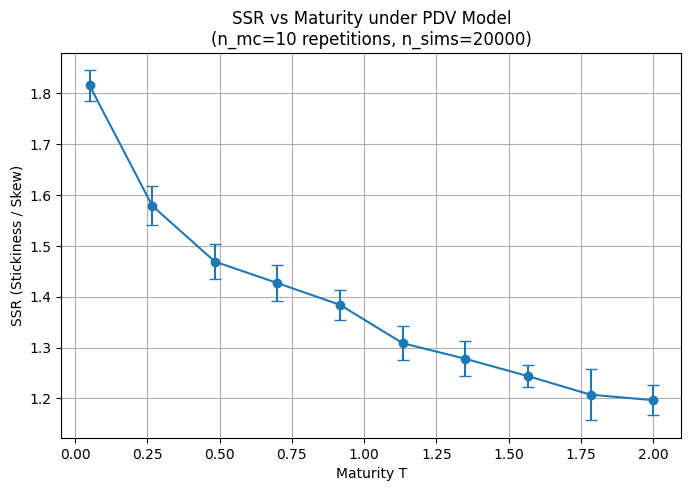

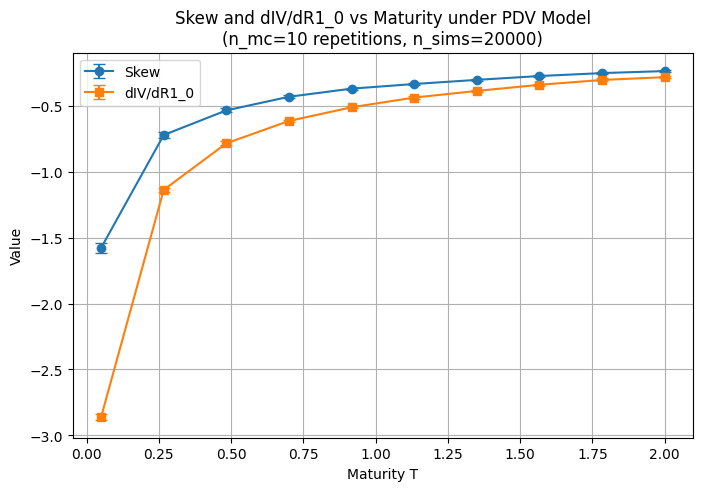

In [55]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
# ---- Configuration ----
S0 = 1
params = {
    'theta1': 0.3,
    'theta2': 0.5,
    'S0': S0,
    'beta': [0.04, -0.13, 0.65],
    'lam1': [55, 10],
    'lam2': [20, 3],
    'T': 0.25,           # Placeholder, will loop over different T
    'n_steps': 400,
    'n_sims': 20000       # adjust for speed vs stability
}

maturities = np.linspace(0.05, 2.0, 10)
n_mc = 10  # number of MC repetitions per T

ssr_means = []
ssr_stds = []
skew_means = []
skew_stds = []
d_iv_means = []
d_iv_stds = []

# ---- Loop over maturities ----
for T in maturities:
    params['T'] = T

    ssr_vals = []
    skew_vals = []
    d_iv_vals = []

    for _ in range(n_mc):
        pdv = PDV(**params)
        try:
            ssr_val, skew_val, d_iv_val = pdv.ssr(eps=1e-5, h=1e-4)
            ssr_vals.append(ssr_val)
            skew_vals.append(skew_val)
            d_iv_vals.append(d_iv_val)
        except Exception as e:
            print(f"Failed for T={T:.2f}: {e}")
            ssr_vals.append(np.nan)
            skew_vals.append(np.nan)
            d_iv_vals.append(np.nan)

    # Compute mean and std ignoring NaNs
    ssr_vals = np.array(ssr_vals)
    skew_vals = np.array(skew_vals)
    d_iv_vals = np.array(d_iv_vals)

    ssr_means.append(np.nanmean(ssr_vals))
    ssr_stds.append(np.nanstd(ssr_vals))

    skew_means.append(np.nanmean(skew_vals))
    skew_stds.append(np.nanstd(skew_vals))

    d_iv_means.append(np.nanmean(d_iv_vals))
    d_iv_stds.append(np.nanstd(d_iv_vals))

# ---- Plot SSR vs Maturity with error bars ----
plt.figure(figsize=(8, 5))
plt.errorbar(maturities, ssr_means, yerr=ssr_stds, fmt='o-', capsize=4)
plt.xlabel('Maturity T')
plt.ylabel('SSR (Stickiness / Skew)')
plt.title(f'SSR vs Maturity under PDV Model\n(n_mc={n_mc} repetitions, n_sims={params["n_sims"]})')
plt.grid(True)
plt.show()

# ---- Plot Skew and dIV/dR1_0 vs Maturity with error bars ----
plt.figure(figsize=(8, 5))
plt.errorbar(maturities, skew_means, yerr=skew_stds, fmt='o-', label='Skew', capsize=4)
plt.errorbar(maturities, d_iv_means, yerr=d_iv_stds, fmt='s-', label='dIV/dR1_0', capsize=4)
plt.xlabel('Maturity T')
plt.ylabel('Value')
plt.title(f'Skew and dIV/dR1_0 vs Maturity under PDV Model\n(n_mc={n_mc} repetitions, n_sims={params["n_sims"]})')
plt.legend()
plt.grid(True)
plt.show()


Statistiques du modèle PDV:
prix_final_moyen: 1.0002
rendement_moyen: -0.0001
volatilite_moyenne: 0.4216
volatilite_std: 0.3699
prix_min: 0.0000
prix_max: 1.5857
option price is  0.0  for strike K = 100
option price is  0.0
option price is  0.0  for strike K = 100
option price is  0.31714691921405763  for strike K = 0.7
option price is  0.29340915787736854  for strike K = 0.7263157894736841
option price is  0.2700311193402567  for strike K = 0.7526315789473683
option price is  0.24705743945869313  for strike K = 0.7789473684210526
option price is  0.2245904060117329  for strike K = 0.8052631578947368
option price is  0.20273108907572251  for strike K = 0.831578947368421
option price is  0.1814732683376276  for strike K = 0.8578947368421053
option price is  0.16087511308983699  for strike K = 0.8842105263157894
option price is  0.1410783502311003  for strike K = 0.9105263157894736
option price is  0.12226786816594258  for strike K = 0.9368421052631578
option price is  0.1045426405694135

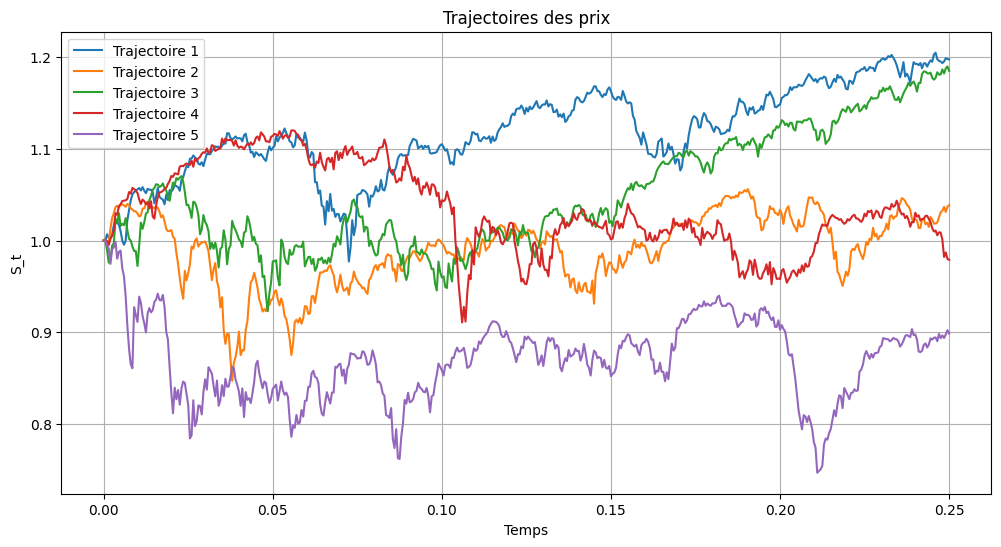

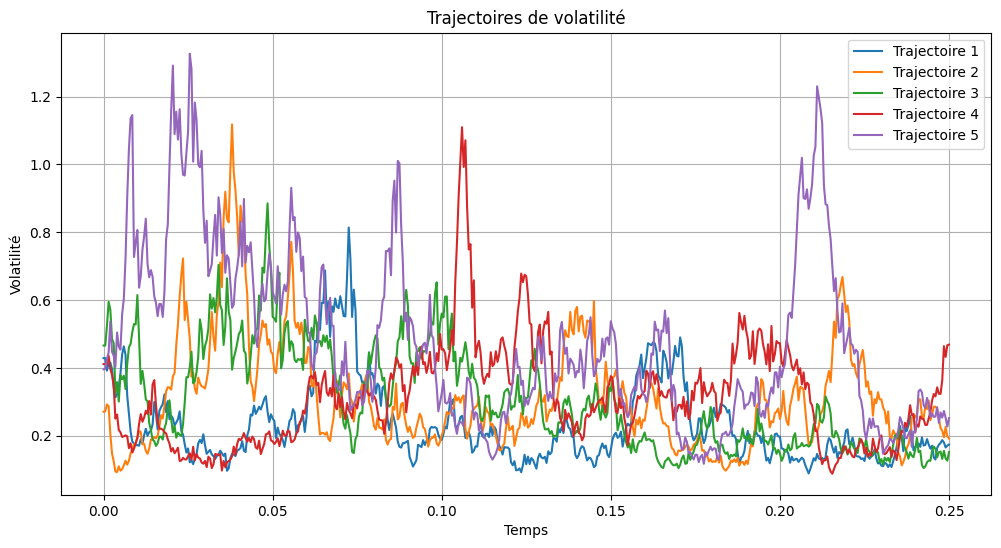

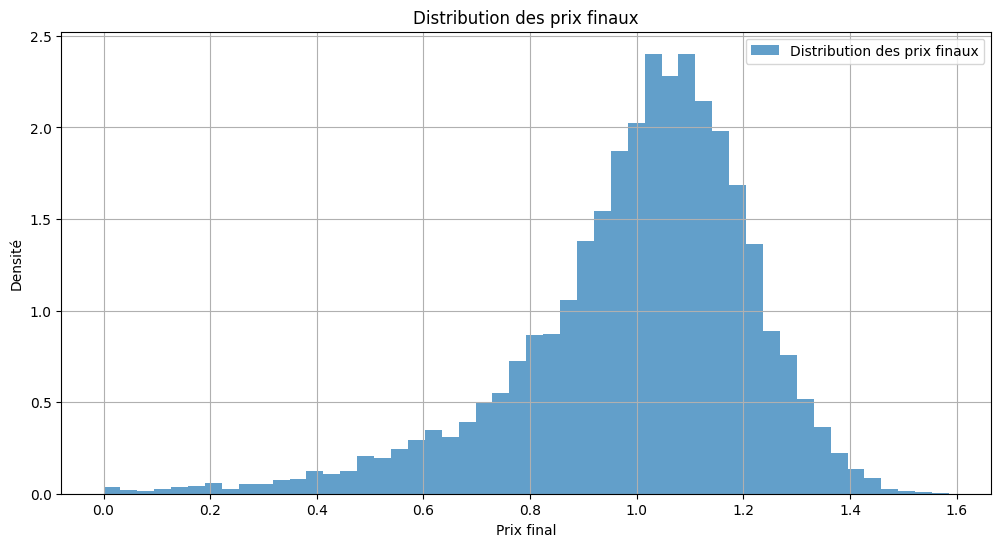

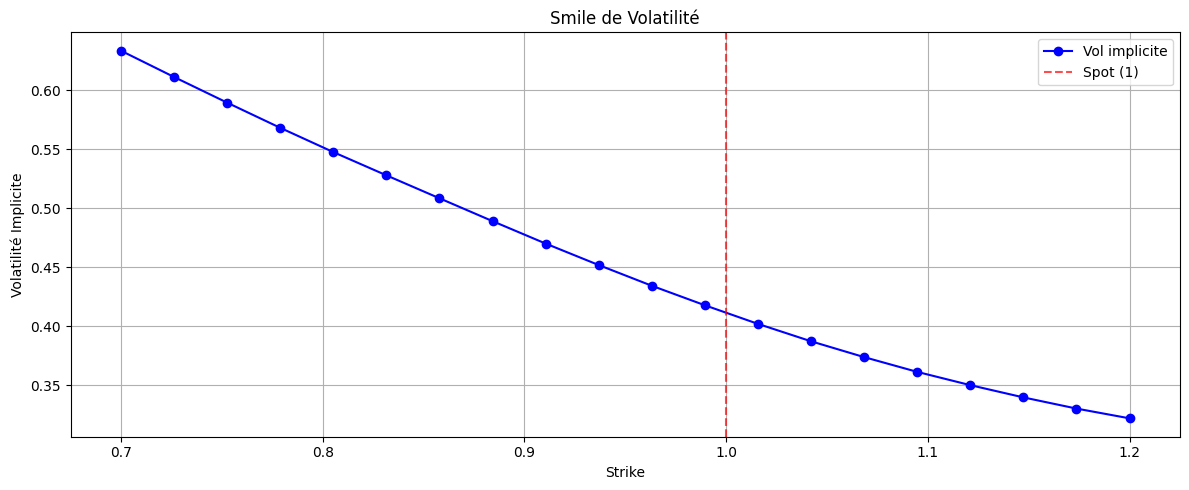

vix t shape is  (20000,)
vis fut price is  42.2313922229985
call prices is  [15.743109422657918, 13.639538518892785, 11.883486668560277, 10.420751585223456, 9.203182263131197, 8.188254926892743, 7.336152044823917, 6.611534307058725, 5.994028886024455, 5.463007668690648]
strike array is  [29.56197456 33.31587609 37.06977762 40.82367915 44.57758068 48.33148221
 52.08538374 55.83928527 59.5931868  63.34708833]
Strike K = 29.56 | Call Price = 15.7431 | Implied Vol = 1.9529
Strike K = 33.32 | Call Price = 13.6395 | Implied Vol = 1.9902
Strike K = 37.07 | Call Price = 11.8835 | Implied Vol = 2.0312
Strike K = 40.82 | Call Price = 10.4208 | Implied Vol = 2.0727
Strike K = 44.58 | Call Price = 9.2032 | Implied Vol = 2.1141
Strike K = 48.33 | Call Price = 8.1883 | Implied Vol = 2.1551
Strike K = 52.09 | Call Price = 7.3362 | Implied Vol = 2.1949
Strike K = 55.84 | Call Price = 6.6115 | Implied Vol = 2.2323
Strike K = 59.59 | Call Price = 5.9940 | Implied Vol = 2.2683
Strike K = 63.35 | Call Pri

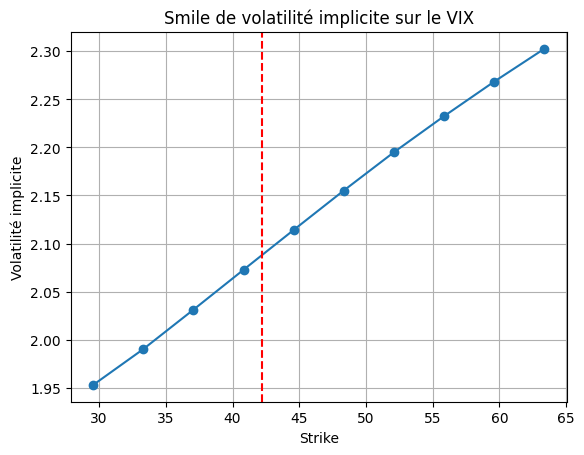

In [29]:

# Exemple d'utilisation
if __name__ == "__main__":
    # Paramètres du modèle
    S0 = 1
    params = {
        'theta1': 0.3,
        'theta2': 0.5,
        'S0': S0,
        'beta': [0.04, -0.13, 0.65],
        'lam1': [55, 10],
        'lam2': [20, 3],
        'T': 0.25,
        'n_steps': 500,
        'n_sims': 10000
    }
    
    # Création et simulation du modèle
    pdv = PDV(**params)
    
    # Conditions initiales (optionnel)
    R1_init = np.random.uniform(0, 1, (params['n_sims'], 2))+0.05
    R2_init = np.random.uniform(0, 1, (params['n_sims'], 2))+0.05
    pdv.set_initial_conditions(R1_init, R2_init)
    
    # Simulation
    trajectories = pdv.simulate_paths()
    
    # Statistiques
    stats = pdv.get_statistics()
    print("Statistiques du modèle PDV:")
    for key, value in stats.items():
        print(f"{key}: {value:.4f}")

    # Prix d'une option call ATM
    call_result = pdv.compute_option_price(K=100, option_type='call')
    print("option price is ",call_result)
    
    market_price_call = call_result  # Prix légèrement supérieur
    iv_result = pdv.compute_implied_volatility(K=100, option_type='call')
    
    # Générer des prix pour différents strikes
    strikes = S0*np.linspace(0.7, 1.2, 20)
    market_prices = []
    
    for K in strikes:
        option_result = pdv.compute_option_price(K=K, option_type='call')
        # Ajouter un peu de bruit pour simuler des prix de marché
        market_price = option_result
        market_prices.append(market_price)
    
    smile_data = pdv.compute_volatility_smile(strikes, market_prices, option_type='call')
    
    print("\nSmile de volatilité:")
    for i, (K, vol) in enumerate(zip(strikes, smile_data)):
        if not np.isnan(vol):
            print(f"Strike {K}: {vol:.2%}")
        else:
            print(f"Strike {K}: Échec du calcul")
    
    
    # Visualisation
    pdv.plot_paths(n_paths=5)
    pdv.plot_volatility_smile(smile_data,strikes)
    res = pdv.price_vix_derivatives(n_subpaths_per_outer=2)

    strikes = res['strike']
    impl_vols = res['vol_implicite']
    call_prices = res['prix_call_VIX']
    vix_future = res['prix_future_VIX']

    # Affichage des résultats
    for K, vol, price in zip(strikes, impl_vols, call_prices):
        print(f"Strike K = {K:.2f} | Call Price = {price:.4f} | Implied Vol = {vol:.4f}")

    # Tracé du smile
    plt.plot(strikes, impl_vols, marker='o')
    plt.axvline(x=vix_future, color='r', linestyle='--')
    plt.title("Smile de volatilité implicite sur le VIX")
    plt.xlabel("Strike")
    plt.ylabel("Volatilité implicite")
    plt.grid(True)
    plt.show()